In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


In [4]:
# Step 1: Load and Preprocess Data
def loadData(filePath="dataset.csv"):
    try:
        dF = pd.read_csv(filePath, encoding='ISO-8859-1')
    except FileNotFoundError:
        print(f"File '{filePath}' not found. Creating sample data for demonstration...")
        dF = createSampleData()

    print(f"Dataset shape: {dF.shape}")

    if 'CustomerID' in dF.columns:
        dF = dF.dropna(subset=['CustomerID'])
        dF['CustomerID'] = dF['CustomerID'].astype(int)

    if 'InvoiceDate' in dF.columns:
        dF['InvoiceDate'] = pd.to_datetime(dF['InvoiceDate'])

    if all(col in dF.columns for col in ['Quantity', 'UnitPrice']):
        dF['TotalPrice'] = dF['Quantity'] * dF['UnitPrice']
        dF = dF[dF['Quantity'] > 0]
        dF = dF[dF['UnitPrice'] > 0]

    print(f"After cleaning, dataset shape: {dF.shape}")
    return dF


def createSampleData():
    np.random.seed(42)
    nCustomers = 500

    customerIds = np.arange(1000, 1000 + nCustomers)
    dates = pd.date_range(start='2023-01-01', end='2023-12-31', periods=nCustomers)

    sampleData = pd.DataFrame({
        'CustomerID': customerIds,
        'InvoiceDate': dates,
        'Quantity': np.random.randint(1, 50, nCustomers),
        'UnitPrice': np.random.uniform(10, 500, nCustomers).round(2)
    })

    sampleData['TotalPrice'] = sampleData['Quantity'] * sampleData['UnitPrice']
    return sampleData


In [5]:
# Step 2: Feature Engineering
def createFeatures(dF):
    requiredCols = ['CustomerID', 'InvoiceDate', 'TotalPrice']
    for col in requiredCols:
        if col not in dF.columns:
            raise ValueError(f"Missing required column: {col}")

    referenceDate = dF['InvoiceDate'].max() + pd.Timedelta(days=1)

    rfm = dF.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (referenceDate - x.max()).days,
        'InvoiceNo': 'nunique' if 'InvoiceNo' in dF.columns else pd.NamedAgg(column='InvoiceDate', aggfunc='count'),
        'TotalPrice': 'sum'
    }).reset_index()

    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    rfm['AvgTransactionValue'] = rfm['Monetary'] / rfm['Frequency']

    customerFirstPurchase = dF.groupby('CustomerID')['InvoiceDate'].min()
    customerFirstPurchase = (referenceDate - customerFirstPurchase).dt.days
    rfm['Tenure'] = rfm['CustomerID'].map(customerFirstPurchase)

    rfm['Tenure'] = rfm['Tenure'].replace(0, 1)
    rfm['MonthlyFrequency'] = rfm['Frequency'] / (rfm['Tenure'] / 30)
    rfm['MonthlyFrequency'] = rfm['MonthlyFrequency'].fillna(0)

    print(f"Created features for {len(rfm)} customers")
    return rfm


In [6]:
# Step 3: Data Normalization
def normalizeData(dF):
    features = ['Recency', 'Frequency', 'Monetary', 'AvgTransactionValue', 'Tenure']

    availableFeatures = [f for f in features if f in dF.columns]
    if len(availableFeatures) < 2:
        raise ValueError(f"Need at least 2 features for clustering. Available: {availableFeatures}")

    x = dF[availableFeatures]

    scaler = StandardScaler()
    scaledX = scaler.fit_transform(x)

    scaledXDF = pd.DataFrame(scaledX, columns=availableFeatures)

    print(f"Normalized {len(availableFeatures)} features")
    return scaledXDF


In [7]:
# Step 4: K-Means Clustering
def applyKmeans(data, numClusters=4):
    if len(data) < numClusters:
        raise ValueError(f"Cannot create {numClusters} clusters with only {len(data)} data points")

    kmeans = KMeans(n_clusters=numClusters,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=42)

    clusterLabels = kmeans.fit_predict(data)

    unique, counts = np.unique(clusterLabels, return_counts=True)
    print(f"\nCreated {numClusters} clusters:")
    for cluster, count in zip(unique, counts):
        percentage = (count / len(clusterLabels)) * 100
        print(f"  Cluster {cluster}: {count} customers ({percentage:.1f}%)")

    return clusterLabels


In [8]:
def visualizeClusters(data, labels):
    pca = PCA(n_components=2)
    data2d = pca.fit_transform(data)

    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(data2d[:, 0], data2d[:, 1],
                          c=labels,
                          cmap='tab10',
                          s=50,
                          alpha=0.7,
                          edgecolor='k',
                          linewidth=0.5)

    plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)', fontsize=12)
    plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)', fontsize=12)
    plt.title('Customer Segmentation Clusters', fontsize=14, fontweight='bold')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Cluster', fontsize=12)

    uniqueLabels = np.unique(labels)
    for label in uniqueLabels:
        size = np.sum(labels == label)
        plt.scatter([], [], c=[plt.cm.tab10(label / len(uniqueLabels))],
                    label=f'Cluster {label}: {size} customers',
                    alpha=0.7)

    plt.legend(title='Clusters', fontsize=10, title_fontsize=11)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

    print(f"PCA variance explained: {pca.explained_variance_ratio_.sum() * 100:.1f}%")


CUSTOMER SEGMENTATION PIPELINE

1. Loading data...
Dataset shape: (541909, 8)
After cleaning, dataset shape: (397884, 9)

2. Creating features...
Created features for 4338 customers

3. Normalizing data...
Normalized 5 features

4. Applying K-Means clustering...

Created 4 clusters:
  Cluster 0: 2653 customers (61.2%)
  Cluster 1: 1660 customers (38.3%)
  Cluster 2: 23 customers (0.5%)
  Cluster 3: 2 customers (0.0%)

5. Visualizing clusters...


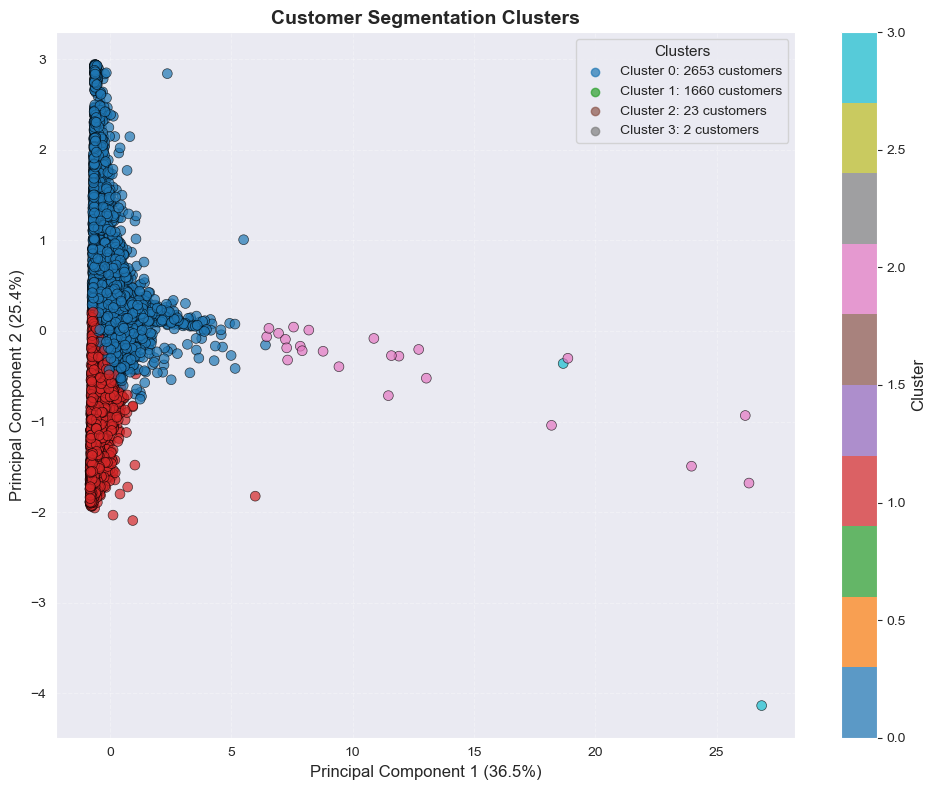

PCA variance explained: 61.9%

Results saved to: customer_segments_results.csv

PIPELINE COMPLETED SUCCESSFULLY!


In [9]:
# Step 6: Main Execution
if __name__ == "__main__":

    print("=" * 60)
    print("CUSTOMER SEGMENTATION PIPELINE")
    print("=" * 60)

    try:
        print("\n1. Loading data...")
        dF = loadData()

        print("\n2. Creating features...")
        dfFeatures = createFeatures(dF)

        print("\n3. Normalizing data...")
        normalizedData = normalizeData(dfFeatures)

        print("\n4. Applying K-Means clustering...")
        clusterLabels = applyKmeans(normalizedData, numClusters=4)

        print("\n5. Visualizing clusters...")
        visualizeClusters(normalizedData, clusterLabels)

        dfFeatures['Cluster'] = clusterLabels
        outputFile = "customer_segments_results.csv"
        dfFeatures.to_csv(outputFile, index=False)
        print(f"\nResults saved to: {outputFile}")

        print("\n" + "=" * 60)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 60)

    except FileNotFoundError as e:
        print(f"\nERROR: File not found: {e}")
        print("Please ensure the data file exists or check the file path.")
    except ValueError as e:
        print(f"\nERROR: Data validation error: {e}")
        print("Please check your data format and columns.")
    except Exception as e:
        print(f"\nERROR: Unexpected error: {e}")
        print("Please check the code and data inputs.")